In [25]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
data = transactions.merge(customers, on='CustomerID', how='left').merge(products, on='ProductID', how='left')

# Check the merged dataset
print(data.head())
print(data.info())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

In [26]:
# Rename 'Price_y' to 'Price' and drop 'Price_x' if it exists
data.rename(columns={'Price_y': 'Price'}, inplace=True)
if 'Price_x' in data.columns:
    data.drop(columns=['Price_x'], inplace=True)

# Verify columns again
print(data.columns)


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'CustomerName', 'Region', 'SignupDate',
       'ProductName', 'Category', 'Price'],
      dtype='object')


In [27]:
# Ensure numeric columns are properly formatted
data['TotalValue'] = pd.to_numeric(data['TotalValue'], errors='coerce')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Ensure non-numeric columns handle empty or invalid data
data['Region'] = data['Region'].astype(str)
data['Category'] = data['Category'].astype(str)


In [28]:
# Aggregate data at the customer level
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total spending
    'TransactionID': 'count',    # Number of transactions
    'Price': 'mean',             # Average product price
    'Region': lambda x: x.mode()[0] if not x.empty else None,  # Most frequent region
    'Category': lambda x: x.mode()[0] if not x.empty else None  # Most frequent product category
}).reset_index()

# Preview the aggregated data
print(customer_features.head())


  CustomerID  TotalValue  TransactionID       Price         Region  \
0      C0001     3354.52              5  278.334000  South America   
1      C0002     1862.74              4  208.920000           Asia   
2      C0003     2725.38              4  195.707500  South America   
3      C0004     5354.88              8  240.636250  South America   
4      C0005     2034.24              3  291.603333           Asia   

      Category  
0  Electronics  
1     Clothing  
2   Home Decor  
3        Books  
4  Electronics  


In [29]:
# If 'Price' is missing, calculate it
if 'Price' not in data.columns and 'TotalValue' in data.columns and 'Quantity' in data.columns:
    data['Price'] = data['TotalValue'] / data['Quantity']
    print("'Price' column calculated from 'TotalValue' and 'Quantity'.")


In [30]:
# Convert 'Region' and 'Category' to numerical values
customer_features = pd.get_dummies(customer_features, columns=['Region', 'Category'])

# Preview the data
print(customer_features.head())


  CustomerID  TotalValue  TransactionID       Price  Region_Asia  \
0      C0001     3354.52              5  278.334000        False   
1      C0002     1862.74              4  208.920000         True   
2      C0003     2725.38              4  195.707500        False   
3      C0004     5354.88              8  240.636250        False   
4      C0005     2034.24              3  291.603333         True   

   Region_Europe  Region_North America  Region_South America  Category_Books  \
0          False                 False                  True           False   
1          False                 False                 False           False   
2          False                 False                  True           False   
3          False                 False                  True            True   
4          False                 False                 False           False   

   Category_Clothing  Category_Electronics  Category_Home Decor  
0              False                  True  

In [31]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns for scaling
numerical_cols = ['TotalValue', 'TransactionID', 'Price']
scaler = StandardScaler()
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Preview the standardized features
print(customer_features.head())


  CustomerID  TotalValue  TransactionID     Price  Region_Asia  Region_Europe  \
0      C0001   -0.061701      -0.011458  0.094670        False          False   
1      C0002   -0.877744      -0.467494 -0.904016         True          False   
2      C0003   -0.405857      -0.467494 -1.094109        False          False   
3      C0004    1.032547       1.356650 -0.447702        False          False   
4      C0005   -0.783929      -0.923530  0.285581         True          False   

   Region_North America  Region_South America  Category_Books  \
0                 False                  True           False   
1                 False                 False           False   
2                 False                  True           False   
3                 False                  True            True   
4                 False                 False           False   

   Category_Clothing  Category_Electronics  Category_Home Decor  
0              False                  True              

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Assuming 'customer_features' is your dataset
# Drop 'CustomerID' as it's an identifier and won't contribute to clustering
features = customer_features.drop(['CustomerID'], axis=1)

# Apply K-Means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Calculate Inertia (Sum of squared distances to the nearest cluster center)
inertia = kmeans.inertia_
print(f"Inertia (Sum of squared distances): {inertia:.4f}")

# Calculate Silhouette Score
# Silhouette score expects features and cluster labels
silhouette_avg = silhouette_score(features, customer_features['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Optional: Print cluster centroids
print("Cluster Centers:")
print(kmeans.cluster_centers_)



Davies-Bouldin Index: 1.2823
Inertia (Sum of squared distances): 698.0585
Silhouette Score: 0.2675
Cluster Centers:
[[ 1.10677546e+00  1.19663704e+00  9.47593874e-02  2.63157895e-01
   1.57894737e-01  2.10526316e-01  3.68421053e-01  4.56140351e-01
   1.92982456e-01  2.10526316e-01  1.40350877e-01  1.77635684e-15
   1.57751516e+00 -4.49313043e-01]
 [-3.31689236e-01 -2.45476636e-01 -5.29542373e-02  2.10526316e-01
   2.89473684e-01  2.36842105e-01  2.63157895e-01  3.02631579e-01
   2.10526316e-01  2.36842105e-01  2.50000000e-01  1.00000000e+00
  -4.08958791e-01  6.50530819e-02]
 [-1.13128013e+00 -8.45352492e-01 -1.35721450e+00  1.71428571e-01
   2.85714286e-01  2.28571429e-01  3.14285714e-01  2.28571429e-01
   4.00000000e-01  1.71428571e-01  2.00000000e-01  2.00000000e+00
  -1.77108395e+00 -8.43091592e-01]
 [ 5.53866146e-02 -6.44024180e-01  1.48792724e+00  2.25806452e-01
   2.90322581e-01  2.58064516e-01  2.25806452e-01  3.22580645e-01
   1.29032258e-01  2.90322581e-01  2.58064516e-01  3.

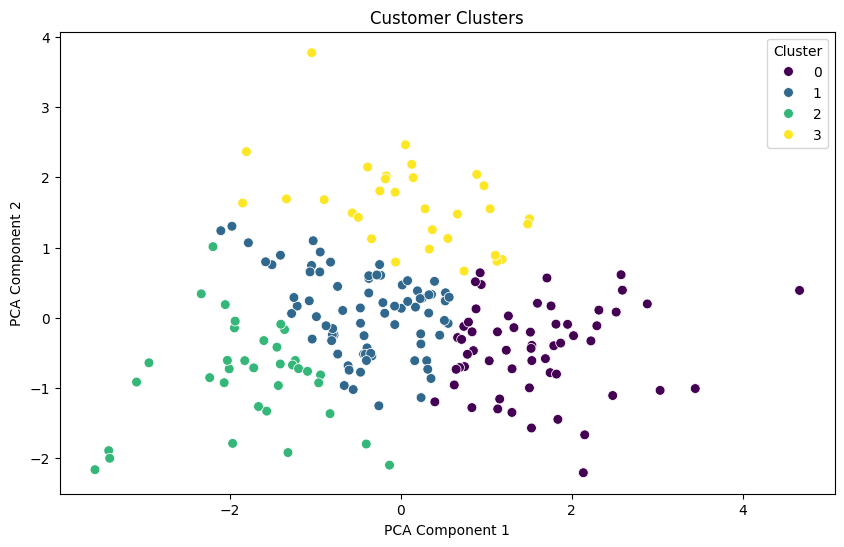

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features.drop(['CustomerID', 'Cluster'], axis=1))

# Add PCA results to the DataFrame
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis', s=50)
plt.title('Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [35]:
# Exclude non-numeric columns
numeric_columns = customer_features.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:", numeric_columns)

# Group by 'Cluster' and calculate the mean for numeric columns
cluster_analysis = customer_features.groupby('Cluster')[numeric_columns].mean()
print(cluster_analysis)


Numeric columns: Index(['TotalValue', 'TransactionID', 'Price', 'PCA1', 'PCA2'], dtype='object')
         TotalValue  TransactionID     Price      PCA1      PCA2
Cluster                                                         
0          1.106775       1.196637  0.094759  1.577515 -0.449313
1         -0.331689      -0.245477 -0.052954 -0.408959  0.065053
2         -1.131280      -0.845352 -1.357214 -1.771084 -0.843092
3          0.055387      -0.644024  1.487927  0.101627  1.618549


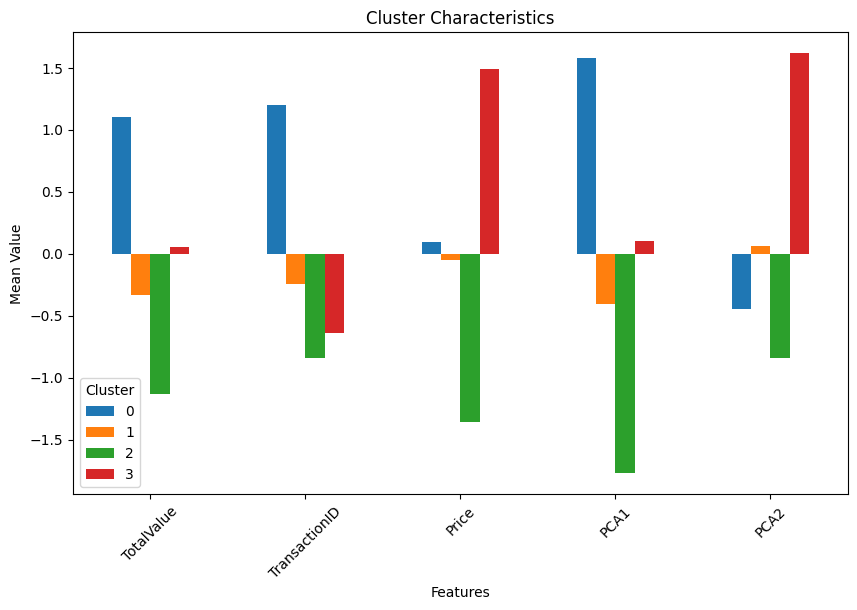

In [36]:
# Plot the cluster characteristics
import matplotlib.pyplot as plt

cluster_analysis.T.plot(kind='bar', figsize=(10, 6), legend=True)
plt.title('Cluster Characteristics')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()
